In [1]:
# common libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium;
import os
from time import time

# for ML libraries:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.metrics import plot_roc_curve, roc_auc_score, make_scorer, fbeta_score, accuracy_score, confusion_matrix, classification_report
 
import eli5 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

random_state=42



# Other Settings
pd.set_option('display.float_format', lambda x: '%.5f' % x)

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_df = pd.read_csv('hotel_bookings.csv')

# data_df = data_df.drop(columns=['reservation_status_date'])

### Alternative data load of file for additional file verification
# data_filename = 'hotel_bookings.csv'
# data_path = os.path.join(os.path.abspath('../Project_Python/Data'), data_filename)
# folder_path = os.path.abspath('../Project_Python/Data')
# data_df = pd.read_csv(data_path)

In [3]:
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
data_df_clean = data_df.fillna(nan_replacements)
data_df_clean["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies - removing entries without guests.
zero_guests = list(data_df_clean.loc[data_df_clean["adults"]
                   + data_df_clean["children"]
                   + data_df_clean["babies"]==0].index)
data_df_clean.drop(data_df_clean.index[zero_guests], inplace=True)
data_df = data_df_clean

In [4]:
data_df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119206.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000
mean,0.37077,104.10923,2016.15647,27.16338,15.79872,0.92705,2.49919,1.85921,0.10405,0.00796,0.03150,0.08719,0.13709,0.21880,74.88908,10.73540,2.32121,101.96909,0.06255,0.57150
std,0.48301,106.87545,0.70749,13.60111,8.78107,0.99512,1.89711,0.57519,0.39884,0.09751,0.17466,0.84492,1.49814,0.63850,107.16888,53.83014,17.59800,50.43401,0.24536,0.79288
min,0.00000,0.00000,2015.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-6.38000,0.00000,0.00000
25%,0.00000,18.00000,2016.00000,16.00000,8.00000,0.00000,1.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,0.00000,0.00000,69.50000,0.00000,0.00000
50%,0.00000,69.00000,2016.00000,28.00000,16.00000,1.00000,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,9.00000,0.00000,0.00000,94.95000,0.00000,0.00000
75%,1.00000,161.00000,2017.00000,38.00000,23.00000,2.00000,3.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,152.00000,0.00000,0.00000,126.00000,0.00000,1.00000
max,1.00000,737.00000,2017.00000,53.00000,31.00000,19.00000,50.00000,55.00000,10.00000,10.00000,1.00000,26.00000,72.00000,18.00000,535.00000,543.00000,391.00000,5400.00000,8.00000,5.00000


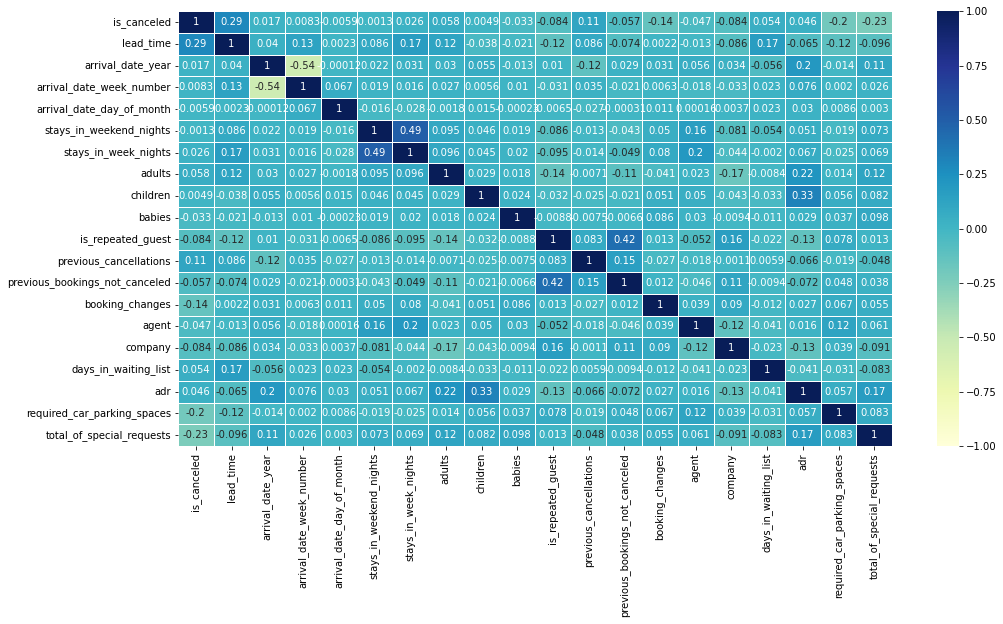

In [5]:
#data_df.corr(method='spearman')

plt.rcParams['figure.figsize']=(16,8)
sns.heatmap(data_df.corr(method='pearson',), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [6]:
cancel_corr = data_df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                        0.29288
total_of_special_requests        0.23488
required_car_parking_spaces      0.19570
booking_changes                  0.14483
previous_cancellations           0.11014
is_repeated_guest                0.08375
company                          0.08359
adults                           0.05818
previous_bookings_not_canceled   0.05737
days_in_waiting_list             0.05430
agent                            0.04677
adr                              0.04649
babies                           0.03257
stays_in_week_nights             0.02554
arrival_date_year                0.01662
arrival_date_week_number         0.00832
arrival_date_day_of_month        0.00595
children                         0.00486
stays_in_weekend_nights          0.00132
Name: is_canceled, dtype: float64

In [7]:
# manually choose columns to include
# Columns ommitted due to issues with model - strange correlations
# ignored_features = ["arrival_date_year", "assigned_room_type", "booking_changes", "reservation_status", "country", "days_in_waiting_list"]


# numerical_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
#                 "stays_in_weekend_nights","stays_in_week_nights","adults","children",
#                 "babies","is_repeated_guest", "previous_cancellations",
#                 "previous_bookings_not_canceled","agent","company",
#                 "required_car_parking_spaces", "total_of_special_requests", "adr"]

# category_features = ["hotel","arrival_date_month","meal","market_segment",
#                 "distribution_channel","reserved_room_type","deposit_type","customer_type"]



#Selected features 

numerical_features = ["lead_time","total_of_special_requests","required_car_parking_spaces","is_repeated_guest","previous_cancellations",
                        "company","days_in_waiting_list", "adults", "previous_bookings_not_canceled"]
category_features = ["market_segment", "distribution_channel","reserved_room_type","deposit_type","customer_type"]


# Separate features and predicted value
features = numerical_features + category_features
X = data_df.drop(["is_canceled"], axis=1)[features]
y = data_df["is_canceled"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value and here no dates are missing.
numerical_features_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
category_features_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
datacleaner = ColumnTransformer(transformers=[("num", numerical_features_transformer, numerical_features),
                                              ("cat", category_features_transformer, category_features)])

In [8]:
datacleaner

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['lead_time', 'total_of_special_requests',
                                  'required_car_parking_spaces',
                                  'is_repeated_guest', 'previous_cancellations',
                                  'company', 'days_in_waiting_list', 'adults',
                                  'previous_bookings_not_canceled']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['market_segment', 'distribution_channel',
                                  'reserved_room_t

In [10]:
# import warnings 
# warnings.filterwarnings('ignore')

# define models to test:
models = [("Dummy_Model:",DummyClassifier(strategy="stratified")),
            ("DecisionTree_Model", DecisionTreeClassifier(random_state=42)),
            ("RandomForest_Model", RandomForestClassifier(random_state=42)),
            ("LogisticRegression_Model", LogisticRegression(random_state=42)),
            ("XGBBoost_Model", XGBClassifier(random_state=42,use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)),
            ("Gaussian_Model", GaussianNB()),
            ("KNN_Model", KNeighborsClassifier())
            ]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('datacleaner', datacleaner), ('model', model)])
    start = time()
    cv_results = cross_val_score(model_steps, X, y, cv=split, scoring="accuracy")
    #fbeta_res = cross_val_score(model_steps, X, y, cv=split, scoring=make_scorer(fbeta_score, beta=0.5))
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    #fbeta_score = round(np.mean(fbeta_res), 4)
    std_dev = round(np.std(cv_results), 4)
    end = time()
    cross_val_time = round(end-start,4)
    print(f"{name}  accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, time: {cross_val_time}")
    ## Removed f-beta: {fbeta_score}  because it was causing issues


Dummy_Model:  accuracy score: 0.536 +/- 0.0013 (std) min: 0.5343, max: 0.5378, time: 0.5961
DecisionTree_Model  accuracy score: 0.8113 +/- 0.0005 (std) min: 0.8105, max: 0.8118, time: 1.7252
RandomForest_Model  accuracy score: 0.8143 +/- 0.0011 (std) min: 0.8131, max: 0.816, time: 24.4849


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression_Model  accuracy score: 0.7997 +/- 0.001 (std) min: 0.798, max: 0.8007, time: 3.3265
XGBBoost_Model  accuracy score: 0.822 +/- 0.0014 (std) min: 0.8203, max: 0.8239, time: 6.7347
Gaussian_Model  accuracy score: 0.5954 +/- 0.0077 (std) min: 0.5883, max: 0.6075, time: 0.8495


Optimized XGBClassifier

In [13]:
XGBmodel_enh = XGBClassifier(n_estimators=160, max_features=0.4, min_samples_split=2, n_jobs=-1, eval_metric='mlogloss', random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('datacleaner', datacleaner), ('model', XGBmodel_enh)])
start = time()
cv_results = cross_val_score(model_steps, X, y, cv=split, scoring="accuracy")
#fbeta_res = cross_val_score(model_steps, X, y, cv=split, scoring=make_scorer(fbeta_score, beta=0.5))
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
#fbeta_score = round(np.mean(fbeta_res), 4)
std_dev = round(np.std(cv_results), 4)
end = time()
cross_val_time = round(end-start,4)
print(f"XGBClassifier Model:  accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, time: {cross_val_time}")



XGBClassifier Model:  accuracy score: 0.5954 +/- 0.0077 (std) min: 0.5883, max: 0.6075, time: 0.8331


In [ ]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['datacleaner'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=category_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = numerical_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,weight,std
0,lead_time,0.32953,0.02171
1,deposit_type_Non Refund,0.19500,0.15864
2,deposit_type_No Deposit,0.11756,0.15065
3,total_of_special_requests,0.07074,0.02004
4,previous_cancellations,0.06120,0.01946
5,market_segment_Online TA,0.04480,0.02332
6,required_car_parking_spaces,0.03130,0.00411
7,adults,0.02056,0.00282
8,customer_type_Transient,0.02024,0.01666
9,market_segment_Offline TA/TO,0.01310,0.01519
